In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import jax
import jax.numpy as jnp
from numpyro import sample, plate, factor
from jax.scipy.special import gammainc, gammaln
from numpyro.distributions import Uniform, Normal, TruncatedNormal
from numpyro.infer import MCMC, NUTS

SPEED_OF_LIGHT = 299792.458

param_labels = {
    "H0": r"$H_0\;[\mathrm{km\,s^{-1}\,Mpc^{-1}}]$",
    "q0": r"$q_0$",
    "j0": r"$j_0$",
    "R": r"$R\;[\mathrm{Mpc}]$",
    "p": r"$p$",
    "q": r"$q$",
}

%matplotlib inline

In [2]:
def load_CF4_data(Vcmb_min=4000, TF_only=True):
    __, Vcmb, mu, e_mu, mu_TF, e_mu_TF = np.genfromtxt("CF4_distances.csv", delimiter=',', unpack=True)

    # Apply minimum Vcmb cut
    mask = Vcmb > Vcmb_min
    Vcmb, mu, e_mu, mu_TF, e_mu_TF = (
        x[mask] for x in (Vcmb, mu, e_mu, mu_TF, e_mu_TF))

    if TF_only:
        mask = np.isfinite(mu_TF)
        return Vcmb[mask], mu_TF[mask], e_mu_TF[mask]
    else:
        return Vcmb, mu, e_mu

In [16]:
def log_prior_r_empirical(r, R, p, q, Rmax_grid, Rmax_truncate=None):
    """
    Log of the (empirical) truncated prior:
        π(r) ∝ r^p * exp(-(r/R)^q),   0 < r ≤ Rmax
    Normalized by Z = [R^(1+p) * γ(a, x)] / n with a = (1+p)/n, x = (Rmax/R)^n
    """
    if Rmax_truncate is None:
        Rmax = Rmax_grid
    else:
        Rmax = jnp.minimum(Rmax_grid, Rmax_truncate)

    a = (1.0 + p) / q
    x = (Rmax / R) ** q

    # log γ(a, x) = log Γ(a) + log P(a, x), P = regularized lower γ
    log_gamma_lower = (
        gammaln(a) + jnp.log(jnp.clip(gammainc(a, x), 1e-300, 1.0)))
    log_norm = (1.0 + p) * jnp.log(R) - jnp.log(q) + log_gamma_lower

    logpdf = p * jnp.log(r) - (r / R)**q - log_norm
    valid = (r > 0) & (r <= Rmax)
    return jnp.where(valid, logpdf, -jnp.inf)


def model(Vcmb, zcmb, mu_obs, e_mu, H0_min=30, H0_max=125.0,
          sample_q0=False, sample_j0=False, q0_default=-0.595, j0_default=1.0,
          which_selection="redshift", k=2):
    nsamples = Vcmb.shape[0]
    # H0 prior
    H0 = sample("H0", Uniform(H0_min, H0_max))
    q0 = sample("q0", Uniform(-10.0, 10.0)) if sample_q0 else q0_default
    j0 = sample("j0", Uniform(-10.0, 10.0)) if sample_j0 else j0_default

    # Predicted distance modulus, assuming that sigma_z = 0
    f = 1.0 + 0.5 * (1.0 - q0) * zcmb - (1.0 / 6.0) * (1.0 - q0 - 3.0 * q0**2 + j0) * zcmb**2
    rhat =  Vcmb / H0 * f  # in Mpc
    mu_hat = 5.0 * jnp.log10(rhat) + 25.0

    if which_selection == "volume":
        extra_term = 0.6 * jnp.log(10) * mu_hat 
        factor("log_prior", extra_term)
    elif which_selection == "magnitude":
        factor("log_prior", - nsamples * (1 + k) * jnp.log(H0))
    elif which_selection == "empirical":
        Rmax_grid = 1000
        R = sample("R", Uniform(1, 1000.0))
        p = sample("p", TruncatedNormal(2, 0.5, low=0.001))
        q = sample("q", TruncatedNormal(1., 10, low=0.001))
        lp_r = log_prior_r_empirical(rhat, R, p, q, Rmax_grid)
        factor("log_prior", lp_r)
    elif which_selection != "redshift":
        raise ValueError(f"Unknown selection function: {which_selection}")

    # likelihood
    with plate("data", nsamples):
        sample("mu", Normal(mu_hat, e_mu), obs=mu_obs)


In [18]:
Vcmb, mu, e_mu = load_CF4_data(4000, )

# ks = np.random.choice(len(Vcmb), size=1000, replace=False)
# Vcmb, mu, e_mu = Vcmb[ks], mu[ks], e_mu[ks]

zcmb = Vcmb / SPEED_OF_LIGHT



nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=1)
mcmc.run(jax.random.PRNGKey(0),
         Vcmb=jnp.asarray(Vcmb),
         zcmb=jnp.asarray(zcmb),
         mu_obs=jnp.asarray(mu),
         e_mu=jnp.asarray(e_mu),
         sample_q0=False,
         sample_j0=False,
         which_selection="magnitude",
         k=2
         )

samples = mcmc.get_samples()
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:00<00:00, 3002.52it/s, 3 steps of size 8.72e-01. acc. prob=0.94]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        H0     66.86      0.14     66.85     66.63     67.08    455.10      1.00

Number of divergences: 0


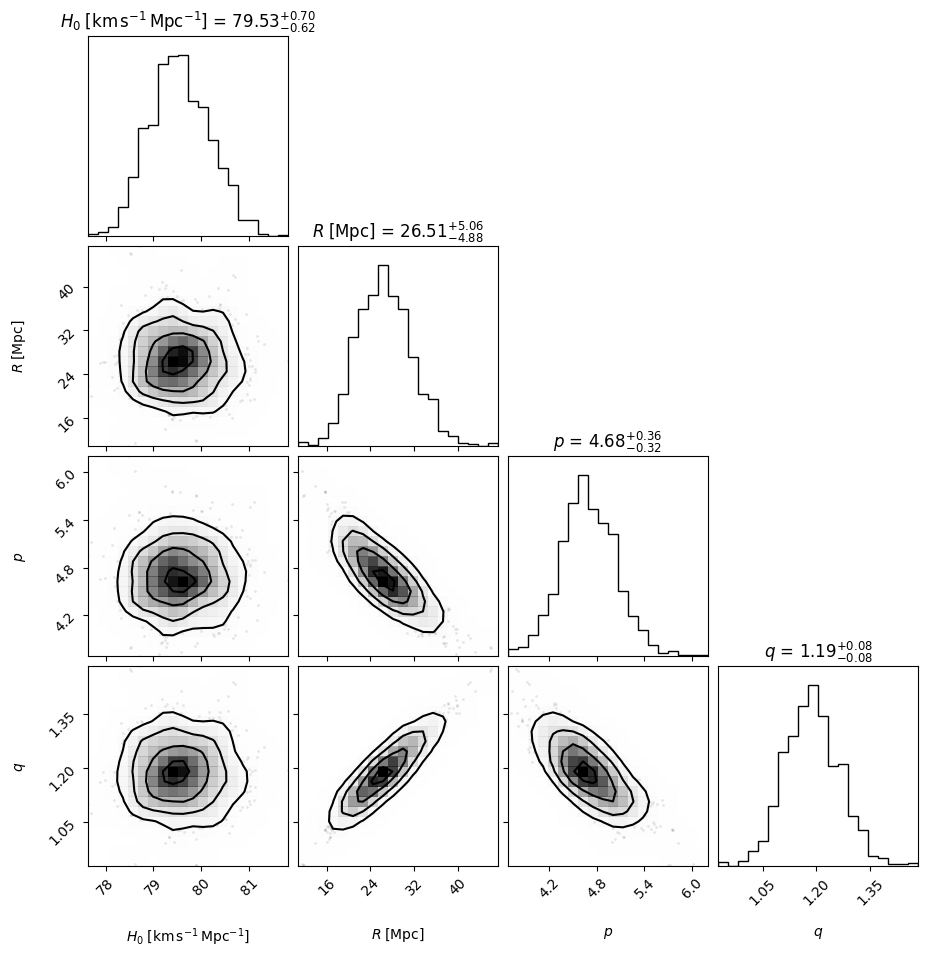

In [92]:
keys = ["H0"] + [k for k in ("q0", "j0", "R", "p", "q") if k in samples]

fig = corner(
    np.column_stack([samples[k] for k in keys]),
    labels=[param_labels[k] for k in keys],
    show_titles=True,
    smooth=1,
)
plt.show()